In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

## Preparación de los datos

Los datos son no linealmente separables y constan de puntos en circunferencias de diferente radio:

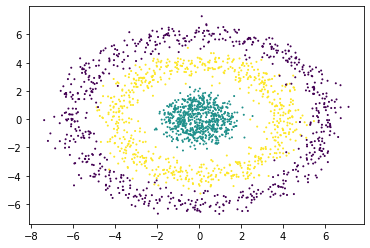

In [2]:
"""
Creación de los datos
"""
r0, r1, r2 = 1, 4, 6
k = 1000
X1 = [np.array([r0*np.cos(t),r0*np.sin(t)]) for t in range(0,k)]
X2 = [np.array([r1*np.cos(t),r1*np.sin(t)]) for t in range(0,k)]
X3 = [np.array([r2*np.cos(t),r2*np.sin(t)]) for t in range(0,k)]
X = np.concatenate((X1,X2,X3))
n,d = X.shape
Y = np.zeros(3*k)
Y[:k] += 1
Y[k:2*k] += 2
noise = np.array([np.random.normal(0,1,2) for i in range(n)])
X += 0.5*noise 

#Seprara en train y en test
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.3)

#Visualización de train set
plt.scatter(x_train[:,0], x_train[:,1],c=y_train,s=1)
plt.show()

#### Arquitectura 

Nuestra red se compondrá de:

* 3 capas ocultas, cada una con 10 unidades ocultas y activación $\tanh$.
* Una capa de salida con tres neuronas (clases de los datos) con activación Softmax.

In [13]:
#Neuronas de entrada
n_input = x_train.shape[1]
#Neuronas en capas ocultas
n_hidden = 10
#Neuronas de salida
n_output = 3

### Entrenamiento

La <b>Inicialización</b> de los parámetros se hará de forma aleatoria y con una varianza $\sqrt{n_k}$

In [14]:
#Semilla
np.random.seed(0)
#Pesos para las capas ocultas
w_1 = np.random.rand(n_hidden, n_input)/np.sqrt(n_input)
b_1 = np.ones(n_hidden)
w_2 = np.random.rand(n_hidden, n_hidden)/np.sqrt(n_hidden)
b_2 = np.ones(n_hidden)
w_3 = np.random.rand(n_hidden, n_hidden)/np.sqrt(n_hidden)
b_3 = np.ones(n_hidden)
#Pesos para la capa de salida
w_output = np.random.rand(n_output, n_hidden)/np.sqrt(n_hidden)
b_output = np.ones(n_output)

Definimos los hiperparámetros del aprendizaje:

* Rango de aprendizaje $\eta = 0.01$
* Número de épocas $T=100$

In [21]:
#Rango de aprendizaje
lr = 0.01
#Número de épocas
epochs = 100

### Entrenamiento con backprop y SGD

El entrenamiento consta de dos pasos:

* <b>Forward</b>: Se calcula el valor de la salidad pasando por las capas ocultas:
    * Preactivación: $a^{(k)} =  W^{(k)}h^{(k-1)}+b^{(k)}$, con $h^{(0)} = x$
    * Activación: $h^{(k)} = \tanh(a^{(1)})$ 
    * Preactivación en salida: $a^{(out)} = W^{(out)}h^{(3)}+b^{(out)}$
    * Activación en salida: $f = Softmax\big(a^{(out)}\big)$
* <b>Bacward</b>: El backward utiliza el algoritmo de backpropagation y el SGD para actualizar. Se calculan las variables de backprop, en base a la función de riesgo $$R(\theta) = -\sum_x \sum_y y \ln f(x)$$ Las variables son:
    * $d_{out}(j) = \frac{\partial R(\theta)}{\partial f_j} \frac{\partial f_j}{\partial a^{(out)}} = f_j - \delta_{y,j}$
    * $d_{k}(j) = \frac{\partial h^{(k)}}{\partial a^{(k)}} \sum_q W^{(k+1)}_{j,q} d_{k+1}(q)$
  
  En este caso, $\frac{\partial h^{(k)}}{\partial a^{(k)}} = 1-\tanh^2(a^{(k)})$. Y tenemos que: $$\delta_{y,j} = \begin{cases} 1 & \text{si } y=j \\ 
  0 & \text{en otro caso} \end{cases}$$

In [22]:
#Guarda la pérdida
loss = []
#Datos para entrenar
train_data = list(zip(x_train,y_train))

for t in tqdm(range(epochs)):
    #Aleatoriza los datos de entrenamiento
    np.random.shuffle(train_data)
    #Guarda el riesgo por época
    risk_epoch = 0
    for x,y in train_data:
        #FORWARD
        #Primera capa
        a_1 = np.dot(w_1, x) + b_1
        h_1 = np.tanh(a_1)
        #Segunda capa
        a_2 = np.dot(w_2, h_1) + b_2
        h_2 = np.tanh(a_2)
        #Tercera capa
        a_3 = np.dot(w_3, h_2) + b_3
        h_3 = np.tanh(a_3)
        #Capa de salida
        a_out = np.dot(w_output, h_3) + b_output
        tmp = np.exp(a_out)
        f = tmp/tmp.sum(0)
        
        #Riesgo en la época
        risk_epoch -= np.log(f)[int(y)]
        
        #BACKWARD
        #Variables de backprop
        #Variable en la salida
        d_out = f.copy()
        d_out[int(y)] -= 1
        #Variables en las capas ocultas
        d_3 = (1-h_3**2)*np.dot(w_output.T, d_out)
        d_2 = (1-h_2**2)*np.dot(w_3.T, d_3)
        d_1 = (1-h_1**2)*np.dot(w_2.T, d_2)
        
        #Actualización de pesos con SGD
        w_output -= lr*np.outer(d_out, h_3)
        w_3 -= lr*np.outer(d_3, h_2)
        w_2 -= lr*np.outer(d_2, h_1)
        w_1 -= lr*np.outer(d_1, x)
        #Actualización de bias con SGD
        b_output -= lr*d_out
        b_3 -= lr*d_3
        b_2 -= lr*d_2
        b_1 -= lr*d_1
    
    #Guarda la pérdida
    loss.append(risk_epoch)
            

100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


### Visualización del riesgo

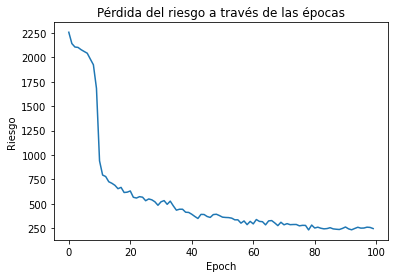

In [23]:
plt.plot(loss)
plt.title('Pérdida del riesgo a través de las épocas')
plt.xlabel('Epoch')
plt.ylabel('Riesgo')
plt.show()

### Evaluación

Para la evaluación utilizamos una función de predicción, y evaluamos usando un reporte de clasificación:

In [24]:
def predict(X):
    """
    Función de predicción de la red neuronal.
    
    Arguments
    ---------
    X : array
        Arreglo de datos de los que se va a predecir
        
    Returns
    -------
        Clases a la que pertenecen los datos según la red.
    """
    #Aplica la red
    a_1 = np.dot(X, w_1.T) + b_1
    h_1 = np.tanh(a_1)
    a_2 = np.dot(h_1, w_2.T) + b_2
    h_2 = np.tanh(a_2)
    a_3 = np.dot(h_2, w_3.T) + b_3
    h_3 = np.tanh(a_3)
    a_out = np.dot(h_3, w_output.T) + b_output
    tmp = np.exp(a_out)
    f = tmp/tmp.sum(1, keepdims=True)
    
    #Regresa el argumento que maximiza el Softmax
    return np.argmax(f, axis=1)

In [25]:
y_pred = predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       298
         1.0       0.99      1.00      1.00       311
         2.0       0.98      0.96      0.97       291

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900



### Estimación de probabilidad de clases

In [26]:
def predict_proba(X):
    """
    Función de estimación de probabilidad de la red neuronal.
    
    Arguments
    ---------
    X : array
        Arreglo de datos de los que se va a predecir
        
    Returns
    -------
        Probabilidad de clase
    """
    #Aplica la red
    a_1 = np.dot(X, w_1.T) + b_1
    h_1 = np.tanh(a_1)
    a_2 = np.dot(h_1, w_2.T) + b_2
    h_2 = np.tanh(a_2)
    a_3 = np.dot(h_2, w_3.T) + b_3
    h_3 = np.tanh(a_3)
    a_out = np.dot(h_3, w_output.T) + b_output
    tmp = np.exp(a_out)
    f = tmp/tmp.sum(1, keepdims=True)
    
    #Regresa la probabilidad por clase
    return f

In [27]:
probs = pd.DataFrame(data=np.round(predict_proba(x_test),4), columns=['Prob. clase 0', 'Prob. clase 1', 'Prob. clase 2'])
probs['Clase'] = y_test
probs #.query('Clase == 2')

,Prob. clase 0,Prob. clase 1,Prob. clase 2,Clase
0,0.9932,0.0000,0.0068,0.0
1,0.1322,0.0008,0.8671,2.0
2,0.0023,0.0000,0.9977,2.0
3,0.0004,0.0004,0.9992,2.0
4,0.0181,0.0005,0.9814,2.0
...,...,...,...,...
895,0.0064,0.0000,0.9936,2.0
896,0.9968,0.0000,0.0032,0.0
897,0.0080,0.0000,0.9920,2.0
898,0.0374,0.0002,0.9623,2.0


### Visualización de la clasificación

(26400, 2)


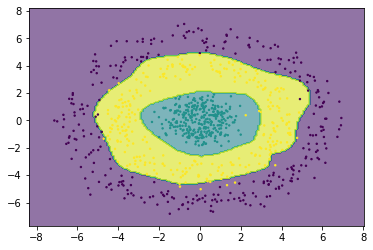

In [28]:
min1, max1 = x_train[:, 0].min()-1, x_train[:, 0].max()+1
min2, max2 = x_train[:, 1].min()-1, x_train[:, 1].max()+1
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
xx, yy = np.meshgrid(x1grid, x2grid)
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
grid = np.hstack((r1,r2))
print(grid.shape)
yhat = predict(grid)
zz = yhat.reshape(xx.shape)
plt.contourf(xx, yy, zz, alpha=0.6)

plt.scatter(x_test[:,0], x_test[:,1],c=y_test,s=2)
plt.show()